# 1. loading datasets

Training has to be done with dropout as data is not always present

In [530]:
import torch
import pandas as pd
import numpy as np
import time
import joblib
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn as nn




In [531]:

from torch import nn 

# Check PyTorch version
print("PyTorch version:", torch.__version__)

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())

# Get current CUDA device index (if available)
if torch.cuda.is_available():
    print("Current CUDA device index:", torch.cuda.current_device())
    print("CUDA device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("No CUDA devices found.")
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


PyTorch version: 2.5.0+cu118
CUDA available: True
Current CUDA device index: 0
CUDA device name: NVIDIA GeForce RTX 4070 SUPER


In [532]:
# Update with the correct path
# file_path = './Data/12_Sep_Readings/combined_data.csv'  
# file_path = './Data/15_Nov_Readings/augmented_rssi_dataset.csv'
model_path = './models/CNN/'

model_name = 'CNN_Attention_HWLab_2fold'
model_data = './Data/CNN_Data/CNN_train_data_2fold'

In [533]:

import pickle

with open( model_data+ '.pkl', 'rb') as f:
    training_samples = pickle.load(f)




In [534]:
if training_samples:
    X_Sequence = np.array([sample[0] for sample in training_samples])  # Shape: (num_samples, Tx, 8)
    y_Sequence = np.array([sample[1] for sample in training_samples])  # Shape: (num_samples, 2) -> (X_Coord, Y_Coord)
else:
    X_Sequence = np.array([])
    y_Sequence = np.array([])

print("Generated training data shape:", X_Sequence.shape)
print("Generated labels shape:", y_Sequence.shape)

Generated training data shape: (11904, 8, 8)
Generated labels shape: (11904, 2)


In [535]:
for i in range(2):
    print(f"Sample {i+1}:")
    print(X_Sequence[i])  # Prints the 8x8 RSSI matrix
    print(f"Label: {y_Sequence[i]}")  # Prints (X_Coord, Y_Coord)
    print("-" * 40)

Sample 1:
[[-61 -61 -62 -61 -61 -61 -61 -61]
 [-74 -73 -75 -73 -75 -75 -75 -75]
 [-79 -78 -78 -80 -78 -78 -78 -79]
 [127 -71 -72 -71 -71 -71 -71 -71]
 [-81 127 -79 -83 -84 -82 -80 -82]
 [-78 -78 127 -78 -78 -80 -78 -78]
 [127 127 -84 127 -84 -82 -84 127]
 [-84 127 127 127 -86 -85 -84 127]]
Label: [0 0]
----------------------------------------
Sample 2:
[[-61 -62 -61 -61 -61 -61 -61 -61]
 [-73 -75 -73 -75 -75 -75 -75 -75]
 [-78 -78 -80 -78 -78 -78 -79 -79]
 [-71 -72 -71 -71 -71 -71 -71 -71]
 [127 -79 -83 -84 -82 -80 -82 -81]
 [-78 127 -78 -78 -80 -78 -78 -78]
 [127 -84 127 -84 -82 -84 127 127]
 [127 127 127 -86 -85 -84 127 127]]
Label: [0 0]
----------------------------------------


In [536]:
from sklearn.model_selection import train_test_split

# Perform train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_Sequence, y_Sequence, test_size=0.2, random_state=42
)

import torch
import numpy as np

# Convert (X_Coord, Y_Coord) to a single class index
y_train = np.array([x * 8 + y for x, y in y_train])
y_test = np.array([x * 8 + y for x, y in y_test])



# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)  # Must be long for classification
y_test = torch.tensor(y_test, dtype=torch.long)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)


# 2. NN model

In [537]:

# # CNN original model
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()

#         # Convolutional Layers
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)   # output size = 8x8x32
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # output size = 4x4x64
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # output size = 4x4x128
#         self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # output size = 4x4x256
#         # Batch Normalization Layers
#         self.batchnorm1 = nn.BatchNorm2d(32)
#         self.batchnorm2 = nn.BatchNorm2d(64)
#         self.batchnorm3 = nn.BatchNorm2d(128)
#         self.batchnorm4 = nn.BatchNorm2d(256)
#         # Fully Connected Layers
#         self.fc1 = nn.Linear(256 * 4 * 4, 512)  # 4x4x256 -> 512
#         self.fc2 = nn.Linear(512, 256)  # 512-> 256
#         self.fc3 = nn.Linear(256, 64)  # 256-> 64

#         # Dropout for regularization
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, x):
#         x = x.unsqueeze(1)  
#         x = F.relu(self.batchnorm1(self.conv1(x)))  
#         x = F.relu(self.batchnorm2(self.conv2(x)))  
#         x = F.relu(self.batchnorm3(self.conv3(x)))  
#         x = F.relu(self.batchnorm4(self.conv4(x))) 

#         x = x.view(x.size(0), -1)  # Flatten

#         x = self.dropout(F.relu(self.fc1(x)))
#         x = self.dropout(F.relu(self.fc2(x)))
#         x = self.fc3(x)  # Output 64 logits (for 64 locations)

#         return x

In [538]:
# # CNN Small Model
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()

#         # Convolutional Layers
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)   # output size = 8x8x32
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # output size = 4x4x64
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # output size = 4x4x128
#         # Batch Normalization Layers
#         self.batchnorm1 = nn.BatchNorm2d(32)
#         self.batchnorm2 = nn.BatchNorm2d(64)
#         self.batchnorm3 = nn.BatchNorm2d(128)

#         # Fully Connected Layers
#         self.fc1 = nn.Linear(128 * 4 * 4, 256)  # 4x4x128 -> 256
#         self.fc2 = nn.Linear(256, 64)  # 256-> 64

#         # Dropout for regularization
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, x):
#         x = x.unsqueeze(1)  
#         x = F.relu(self.batchnorm1(self.conv1(x)))  
#         x = F.relu(self.batchnorm2(self.conv2(x)))  
#         x = F.relu(self.batchnorm3(self.conv3(x)))  

#         x = x.view(x.size(0), -1)  # Flatten

#         x = self.dropout(F.relu(self.fc1(x)))
#         x = self.fc2(x)  # Output 64 logits (for 64 locations)

#         return x

In [539]:
# CNN Attention Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)   # output size = 8x8x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # output size = 4x4x64
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # output size = 4x4x128
        # Batch Normalization Layers
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.batchnorm3 = nn.BatchNorm2d(128)
        
        # Attention Layer (1 filter, 1x1 conv + sigmoid)
        self.attention = nn.Conv2d(128, 1, kernel_size=1)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # 4x4x128 -> 256
        self.fc2 = nn.Linear(256, 64)  # 256-> 64

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.unsqueeze(1)  
        x = F.relu(self.batchnorm1(self.conv1(x)))  
        x = F.relu(self.batchnorm2(self.conv2(x)))  
        x = F.relu(self.batchnorm3(self.conv3(x)))  

        attn_weights = torch.sigmoid(self.attention(x))  # Compute attention weights (4x4x1)
        x = x * attn_weights 

        x = x.view(x.size(0), -1)  # Flatten

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)  # Output 64 logits (for 64 locations)

        return x

In [540]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [541]:
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (attention): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [542]:
# Training loop
num_epochs = 200
patience = 10
batch_size = 32
best_val_loss = float('inf')
epochs_without_improvement = 0

In [543]:
import numpy as np
import time

train_losses = []
val_losses = []
val_ade = []
start_time = time.time()

# Move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Create DataLoader for mini-batch training
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

best_val_loss = float("inf")
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0  # Track loss across mini-batches

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU

        optimizer.zero_grad()  # Reset gradients
        outputs = model(inputs)  # Mini-batch forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()  # Accumulate loss

    avg_train_loss = running_loss / len(train_loader)  # Compute avg loss

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test).item()

        # Compute Average Displacement Error (ADE)
        predicted_classes = torch.argmax(val_outputs, dim=1).cpu().numpy()  # Class indices (0-63)
        actual_classes = y_test.cpu().numpy()

        # Convert class indices to (X, Y) coordinates
        predicted_x = predicted_classes % 8
        predicted_y = predicted_classes // 8
        predicted_coords = np.stack((predicted_x, predicted_y), axis=1)

        actual_x = actual_classes % 8
        actual_y = actual_classes // 8
        actual_coords = np.stack((actual_x, actual_y), axis=1)

        # Compute Euclidean distances
        displacements = np.linalg.norm(predicted_coords - actual_coords, axis=1)
        average_displacement = np.mean(displacements)

    # Store losses and ADE
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    val_ade.append(average_displacement)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, ADE: {average_displacement:.4f} grid units")

total_training_time = time.time() - start_time
print(f"Total training time: {total_training_time:.2f} seconds")


Epoch [10/200], Train Loss: 0.2994, Val Loss: 0.3301, ADE: 0.3302 grid units
Epoch [20/200], Train Loss: 0.1256, Val Loss: 0.2460, ADE: 0.2345 grid units
Epoch [30/200], Train Loss: 0.0771, Val Loss: 0.1933, ADE: 0.1853 grid units
Epoch [40/200], Train Loss: 0.0497, Val Loss: 0.1820, ADE: 0.1753 grid units
Early stopping at epoch 49
Total training time: 42.01 seconds


In [544]:
torch.save(model, model_path+model_name+".pth")  


In [545]:
model.eval()
model.to(device)

# Select first 10 samples for testing
inputs = X_test[:10]
actual_targets = y_test[:10]


inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
with torch.no_grad():
    preds = model(inputs)
predicted_coords = torch.round(preds).to(torch.int).cpu().numpy()
actual_targets = actual_targets.cpu().numpy()

# print("Predicted X and Y coordinates:")
# print(predicted_coords)  

# print("\nActual X and Y coordinates:")
# print(actual_targets)

predicted_classes = torch.argmax(preds, dim=1).cpu().numpy()
predicted_x = predicted_classes % 8
predicted_y = predicted_classes // 8
predicted_coords = np.stack((predicted_x, predicted_y), axis=1) 

print("Predicted X and Y coordinates:")
print(predicted_coords)  

# Convert actual class indices to (X, Y) coordinates
actual_x = actual_targets % 8
actual_y = actual_targets // 8
actual_coords = np.stack((actual_x, actual_y), axis=1)  

print("\nActual X and Y coordinates:")
print(actual_coords)

# Shape: [x,y]

Predicted X and Y coordinates:
[[6 1]
 [2 1]
 [5 0]
 [2 2]
 [0 2]
 [6 4]
 [7 0]
 [5 0]
 [3 3]
 [2 6]]

Actual X and Y coordinates:
[[6 1]
 [2 1]
 [5 0]
 [2 2]
 [0 2]
 [6 4]
 [7 0]
 [5 0]
 [3 3]
 [4 3]]


C:\Users\randa\AppData\Local\Temp\ipykernel_16016\180245204.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).to(device)


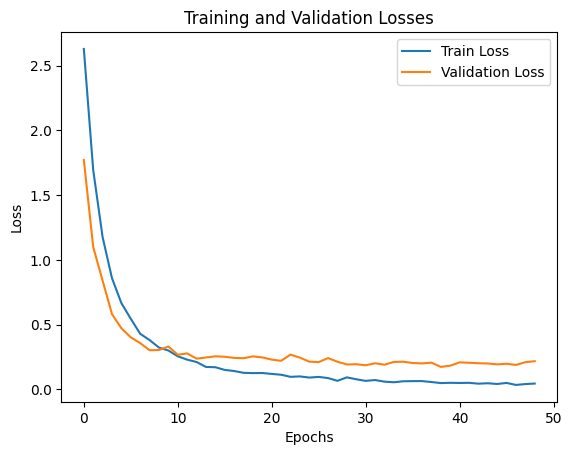

In [546]:
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.savefig("./Figures/training_loss_plot_CNN.png")  # Save as PNG file
plt.show()